In [1]:
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import torch
from torch.utils.data import DataLoader
from torch import optim

import flair

from dataset.dataset_batcher import SlimDataset
from models.SLIM import SLIM

from dataset.preprocessing import get_mini_batch
from helpers.train_helper import Trainer
from helpers.early_stopping import EarlyStopping
from helpers.scheduler import LinearDecayLR


  ## Notes:
  Do not forget to run the below command before starting the script
  `python -m visdom.server`

 ### Imports

In [2]:
# source: https://github.com/NVIDIA/framework-determinism/blob/master/pytorch.md

import random
import numpy as np

seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
CUDA_LAUNCH_BLOCKING = 1


 ### Initialize some variables


In [3]:
dataset_dir = "/home/guszarzmo@GU.GU.SE/Corpora/slim/turk_data_torch_flair/"
model_path = "/home/guszarzmo@GU.GU.SE/LT2318/aics-project/data/models/"

file_batch = 1
no_mini_batch = 0
bert_hidden_size = 768
views_emb_size = 4
image_width = 64
image_height = 64
image_color = 3

lr_init = 5e-4
lr_final = 5e-5
step_num = 1e6

CAPTION_ENC_SZ = 64
VIEWS_ENC_SZ = 32
SC_r_SZ = 256
ITER_NUM = 12
DRAW_h_SZ = 128
DRAW_Z_SZ = 3

MINI_BATCH_SZ = 32
SAMPLE_NUM = 3200
EPOCH_STEP = int(SAMPLE_NUM / MINI_BATCH_SZ)
CHECK_POINT = EPOCH_STEP * 5

model_parameters = {
    "caption_embs_size": CAPTION_ENC_SZ,
    "views_emb_size": views_emb_size,
    "views_enc_size": VIEWS_ENC_SZ,
    "scene_rep_size": SC_r_SZ,
    "image_width": image_width,
    "image_height": image_height,
    "image_color": image_color,
    "iter_num": ITER_NUM,
    "draw_h_size": DRAW_h_SZ,
    "z_size": DRAW_Z_SZ,
}


 ### Auotomatic GPU selection

In [4]:
# Select cuda device based on the free memory
# Most of the time some cudas are busy but available
# torch.cuda.empty_cache()
use_cpu = False

from utils.gpu_cuda_helper import get_gpus_avail

cuda_idx = get_gpus_avail()
device = None
if not cuda_idx:
    device = torch.device("cpu")
elif len(cuda_idx) >= 1:
    cuda_id = cuda_idx[0][0]
    device = torch.device(f"cuda:{cuda_id}")

if use_cpu:
    device = torch.device("cpu")

print(f"\ndevice selected: {device}")
flair.device = device


 cuda id   Memory usage  
    0          0.00%     
    1          0.09%     
    2          0.09%     

device selected: cuda:0


 ### Initialize plotting class

In [5]:
from utils.visualization import Visualizations

# Visualization
vis = Visualizations()


Setting up a new session...


 ### DataLoader

In [5]:


def custom_collate(data):
    return data


train_dataset = SlimDataset(root_dir=dataset_dir + "train")

val_dataset = SlimDataset(root_dir=dataset_dir + "valid")

test_dataset = SlimDataset(root_dir=dataset_dir + "test")

train_iter = DataLoader(train_dataset,
                        batch_size=1,
                        shuffle=True,
                        num_workers=4,
                        pin_memory=device.type == "cuda",
                        collate_fn=custom_collate)

val_iter = DataLoader(val_dataset,
                      batch_size=1,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=device.type == "cuda",
                      collate_fn=custom_collate)

test_iter = DataLoader(test_dataset,
                       batch_size=file_batch,
                       shuffle=True,
                       num_workers=2,
                       collate_fn=custom_collate)


 ### Construct the model

In [7]:
model = SLIM(model_parameters)
model = model.to(device)
# if cuda_idx:
#     model = nn.DataParallel(model, cuda_idx)


In [8]:

optimizer = optim.Adam(model.parameters(), lr=lr_init)
scheduler = LinearDecayLR(optimizer)


 ### Model Train

In [9]:

print()
slim_train = Trainer(model,
                     device,
                     epoch_interval=EPOCH_STEP,
                     save_path=model_path,
                     check_model_size=False)

# print(f"Model memory Size: {slim_train.model_memory_gb:.2f} GB")


In [10]:
# early stopping
es = EarlyStopping(patience=3, min_delta=0.1)


In [11]:
check_grad = False
resume = True

if resume:
    model_name = "slim_18-03-08h06_7485.pt"
    load_path = model_path + model_name
    model_data = torch.load(load_path, map_location=device)
    model_state_dict = model_data["model_state_dict"]
    optimizer_state_dict = model_data["optimizer_state_dict"]
    scheduler_state_dict = model_data["scheduler_state_dict"] 
    model.load_state_dict(model_state_dict)
    optimizer.load_state_dict(optimizer_state_dict)
    scheduler.load_state_dict(scheduler_state_dict)
    
    slim_train.global_steps = model_data["steps"]
    slim_train.best_loss = model_data["loss"]


while slim_train.in_train:
    slim_train.local_steps = 0  # 1 epoch = SAMPLE_NUM local steps
    slim_train.train_loss = 0

    # train
    with tqdm(train_iter, leave=False, unit="file") as train_pb:
        # load one file (max 64 samples per file)
        for train_batch in train_pb:
            # progress bar one step
            train_pb.set_description(f"LocalStep {slim_train.local_steps}")

            trn_mini_b = get_mini_batch(data=train_batch[0],
                                        size_=MINI_BATCH_SZ)

            with tqdm(trn_mini_b, leave=False, unit="minibatch") as minipb:
                minipb.set_description("minibatch train")

                # train min batches
                for data in minipb:
                    slim_train.train(model, optimizer, scheduler, data,
                                     check_grad)

                    # update progress bars
                    minipb.set_postfix({"train loss": slim_train.train_loss})
                    slim_train.postfix["train loss"] = slim_train.train_loss
                    slim_train.trainpb.set_postfix(slim_train.postfix)

                    if check_grad:
                        vis.plot_grad_norm(slim_train.total_norm,
                                           slim_train.global_steps + 1,
                                           "average gradient norm")

                    # eval, each CHECK_POINT steps (every 5 epochs)
                    if slim_train.global_steps % (
                            CHECK_POINT -
                            1) == 0 or slim_train.global_steps == 0:
                        model_tested = True
                        slim_train.val_loss = 0
                        slim_train.val_steps = 0
                        for val_batch in val_iter:
                            val_mini_batches = get_mini_batch(
                                data=val_batch[0], size_=1)
                            slim_train.eval(model, val_mini_batches)

                        slim_train.val_loss = \
                            slim_train.val_loss / slim_train.val_steps

                        # update main progress bar
                        slim_train.postfix["test loss"] = slim_train.val_loss
                        slim_train.trainpb.set_postfix(slim_train.postfix)

                        # plot validation
                        vis.plot_loss(slim_train.val_loss,
                                      slim_train.global_steps + 1,
                                      "Validation")

                        # save model
                        val_loss = round(slim_train.val_loss, 2)
                        best_loss = round(slim_train.best_loss, 2)
                        if val_loss <= best_loss:
                            slim_train.best_loss = slim_train.val_loss
                            slim_train.save_checkpoint(model, optimizer,
                                                       scheduler)

                        # early stopping
                        if es.step(slim_train.val_loss):
                            slim_train.train_loss = \
                                slim_train.train_loss / slim_train.local_steps
                            slim_train.in_train = False

                    # plot
                    if slim_train.global_steps % 3 == 0:
                        vis.plot_loss(slim_train.train_loss,
                                      slim_train.global_steps + 1, "Train")

                    if slim_train.epoch_finished or not slim_train.in_train:
                        break

            if slim_train.epoch_finished or not slim_train.in_train:
                slim_train.epoch_finished = False
                minipb.close()
                train_pb.close()
                if not slim_train.in_train:
                    print("\nTraining finished ...")
                break


RuntimeError: CUDA out of memory. Tried to allocate 34.00 MiB (GPU 1; 10.92 GiB total capacity; 10.12 GiB already allocated; 23.50 MiB free; 10.22 GiB reserved in total by PyTorch)

 ### Load the best model

In [6]:

# change device
torch.device("cuda:0")
flair.device = device
model_name = "slim_18-03-08h06_7485.pt"
load_path = model_path + model_name
model_data = torch.load(load_path, map_location=device)
model_state_dict = model_data["model_state_dict"]

model_inference = SLIM(model_parameters)
model_inference = model_inference.to(device)
model_inference.load_state_dict(model_state_dict)



<All keys matched successfully>

### Tesing Model

In [7]:
import pandas as pd

model_inference.eval()
test_loss = []
images_r = []
images_g = []
images_t = []
captions = []
view_image = []
views = []
test_steps = 0

with tqdm(test_iter, unit="file") as testpb:
    for test_batch in testpb:
        test_mini_batches = get_mini_batch(
            data=test_batch[0], size_=1)
        
        for mini_batch in test_mini_batches:
            testpb.set_description(f"Testing Step {test_steps}")
            with torch.no_grad():
                image, loss = model_inference(mini_batch)
                # generate image
                images_r.append(image)
                image_g = model_inference.generate(mini_batch)
                images_g.append(image_g.cpu())
                images_t.append(mini_batch[0])
                captions.append(mini_batch[3])
                view_image.append(mini_batch[1])
                views.append(mini_batch[2]) 
                
                test_loss.append(loss.item())
                test_steps += 1
data_dict = {"GroundTruth": images_t,
             "ImageGen": images_g,
             "ImageRecon": images_r,
             "ImageView": view_image,
             "SceneViews": views,
             "Captions": captions,
             "loss": test_loss}

test_df =  pd.DataFrame(data_dict)
test_df.index.name = "serial"

### Loss Calculation

In [8]:
test_loss = np.array(test_loss)
loss_average = np.mean(test_loss)
loss_res = np.std(test_loss)
max_loss = np.max(test_loss)
min_loss = np.min(test_loss)

print(f"minimum loss: {min_loss:.3f}")
print(f"maximum loss: {max_loss:.3f}")
print(f"loss:         {loss_average:.2f} \u00B1 {loss_res:0.2f}")


minimum loss: 28.006
maximum loss: 257.024
loss:         101.38 ± 31.61


### PLot Images

In [44]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def plot_grid(df):
    plt.figure(figsize=(20, 12))

    plt.subplot(311)
    img = torch.squeeze(torch.stack(df.GroundTruth.to_list())).cpu()
    grid = make_grid(img).permute(1, 2, 0).numpy()
    plt.imshow(grid, interpolation="nearest")
    plt.title("Ground Truth")

    plt.subplot(312)
    img = torch.squeeze(torch.stack(df.ImageRecon.to_list())).cpu()
    grid = make_grid(img).permute(1, 2, 0).numpy()
    plt.imshow(grid, interpolation="nearest")
    plt.title("Reconstructed")

    plt.subplot(313)
    img = torch.squeeze(torch.stack(df.ImageGen.to_list())).cpu()
    grid = make_grid(img).permute(1, 2, 0).numpy()
    plt.imshow(grid, interpolation="nearest")
    plt.title("Generated")


    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


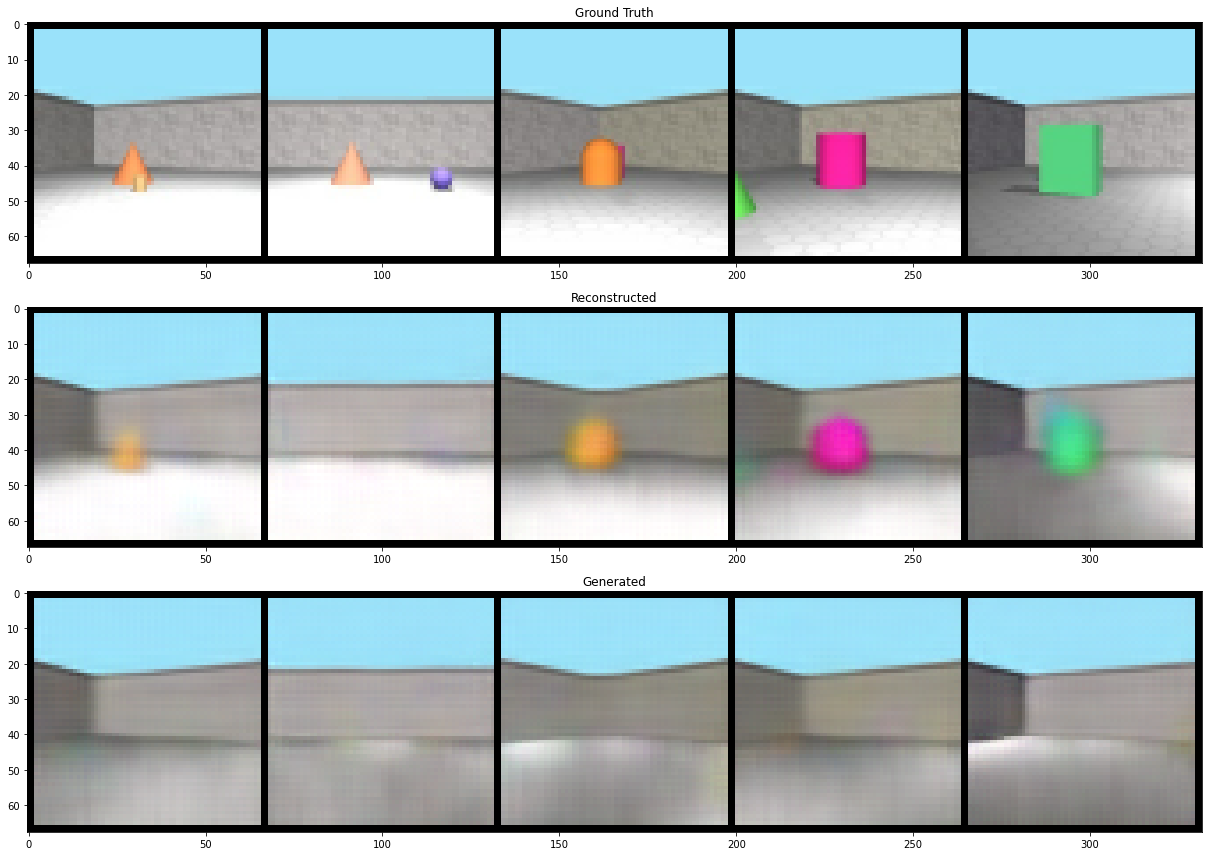

In [45]:
best_samples_df = test_df.nsmallest(5, 'loss', keep='all')
plot_grid(best_samples_df)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


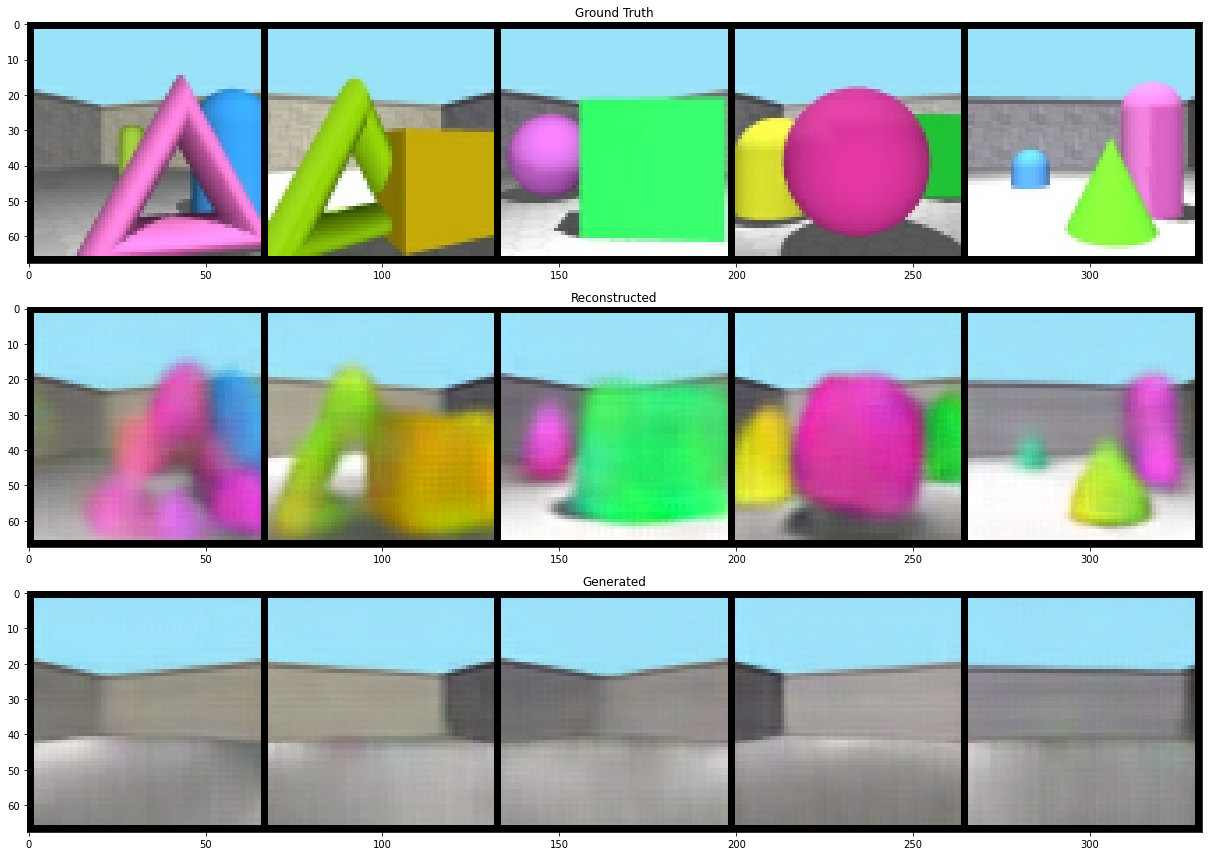

In [46]:
worst_samples_df = test_df.nlargest(5, 'loss', keep='all')
plot_grid(worst_samples_df)

### Change Views

In [43]:
j = random.randint(0,8) 
image_true = best_samples_df.GroundTruth.to_list()[0]
image_vw = best_samples_df.ImageView.to_list()[0]
views_other = best_samples_df.SceneViews.to_list()[0]
captions = best_samples_df.Captions.to_list()[0]

images_g = []
images_r = []
for j in tqdm(range(9)):
    views_other_ = views_other[:, j, :].view(1, 1, -1)
    captions_text = captions[j:j+1]
    mybatch = [image_true, image_vw, views_other_, captions_text]
    image, loss = model_inference(mybatch)
    image_g = model_inference.generate(mini_batch)

    images_r.append(image)
    images_g.append(image_g)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Generated')

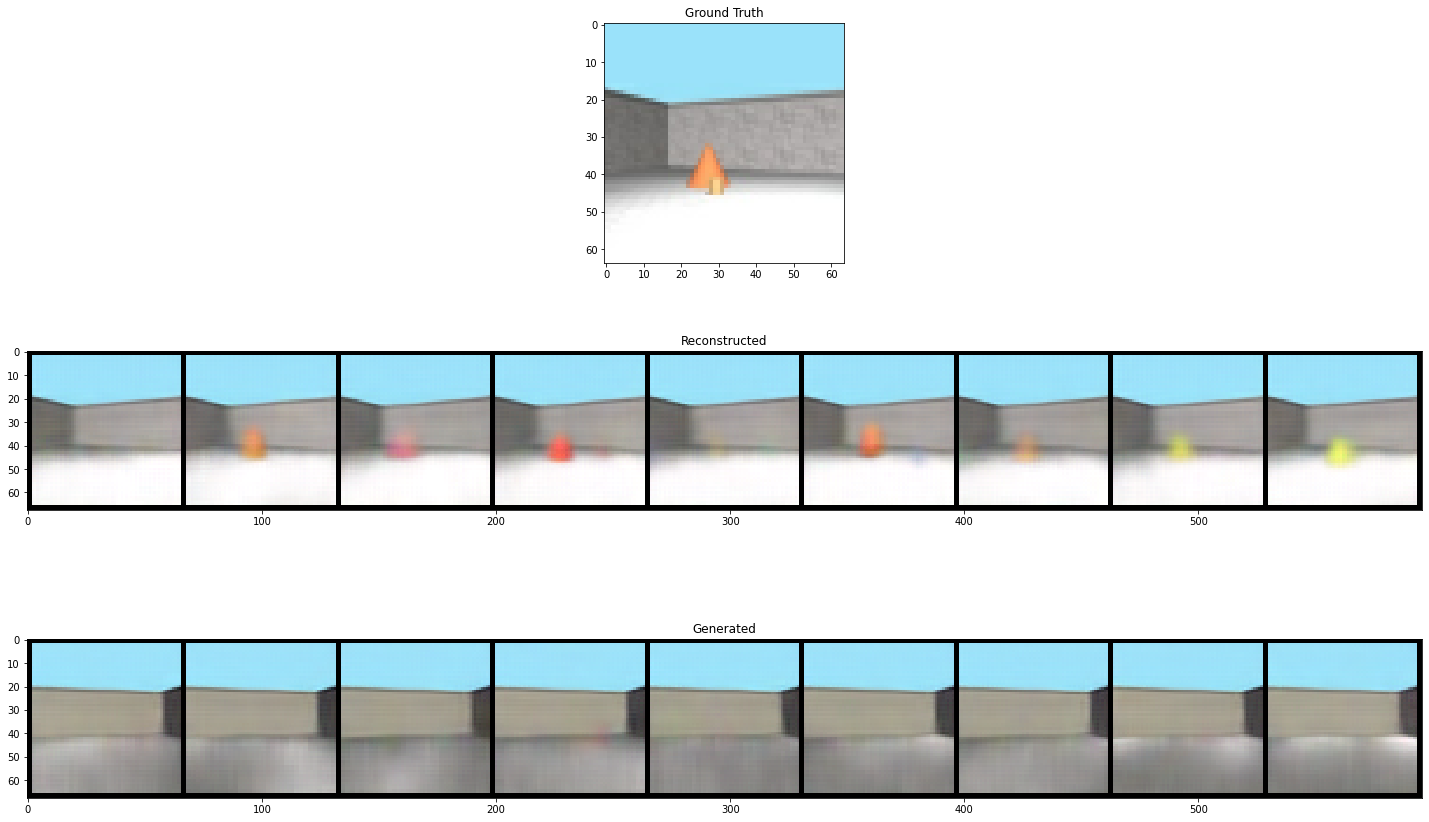

In [60]:
plt.figure(figsize=(25, 15))

plt.subplot(311)
img = image_true.cpu()
grid = make_grid(img).permute(1, 2, 0).numpy()
plt.imshow(grid, interpolation="nearest")
plt.title("Ground Truth")

plt.subplot(312)
img = torch.squeeze(torch.stack(images_r)).cpu()
grid = make_grid(img, nrow=9).permute(1, 2, 0).detach().numpy()
plt.imshow(grid, interpolation="nearest")
plt.title("Reconstructed")

plt.subplot(313)
img = torch.squeeze(torch.stack(images_g)).cpu()
grid = make_grid(img, nrow=9).permute(1, 2, 0).detach().numpy()
plt.imshow(grid, interpolation="nearest")
plt.title("Generated")